# Pneumonia Detection
[Notebook Link on Kaggle](https://www.kaggle.com/code/marihamrezk/pneumonia-pytorch)

## 1. Important Libraries

In [1]:
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,precision_recall_fscore_support 

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 
import pandas as pd
import os
import random
import itertools

#!pip install torchinfo
from torchinfo import summary
#!pip install seaborn
import seaborn as sns

#!pip install torch_lr_finder
from torch_lr_finder import LRFinder

## 2. Constants and Parameters

In [2]:
data_dir='/kaggle/input/chest-xray-pneumonia/chest_xray'
num_classes=2
epochs=16
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 3. Dataset

### 3.1 Creating Train/Test/Val Splits

In [3]:
Train_set = datasets.ImageFolder(os.path.join(data_dir,"train"),transform = transforms.ToTensor())
Test_set = datasets.ImageFolder(os.path.join(data_dir,"test"),transform = transforms.ToTensor())
Dev_set = datasets.ImageFolder(os.path.join(data_dir,'val'),transform = transforms.ToTensor())

### 3.2 Exploring Dataset 

In [4]:
print("Train set:",len(Train_set))
print("Test set:",len(Test_set))
print("Dev set:",len(Dev_set))

Train set: 5216
Test set: 624
Dev set: 16


#### 3.2.1 Classes number and distribution

In [5]:
print(f"Dataset Classes: {Train_set.classes}")
print(f"Dataset Label: {Train_set.class_to_idx}")

print(f"Dataset Classes: {len(Train_set.classes[0])}")

Dataset Classes: ['NORMAL', 'PNEUMONIA']
Dataset Label: {'NORMAL': 0, 'PNEUMONIA': 1}
Dataset Classes: 6


In [6]:
# Dictionary to convert label to class name

'''for k in Train_set.class_to_idx:
  print (k,Train_set.class_to_idx[k])
  break'''
idx_to_class = {Train_set.class_to_idx[k]: k for k in Train_set.class_to_idx}
idx_to_class

{0: 'NORMAL', 1: 'PNEUMONIA'}

Classes Distribution

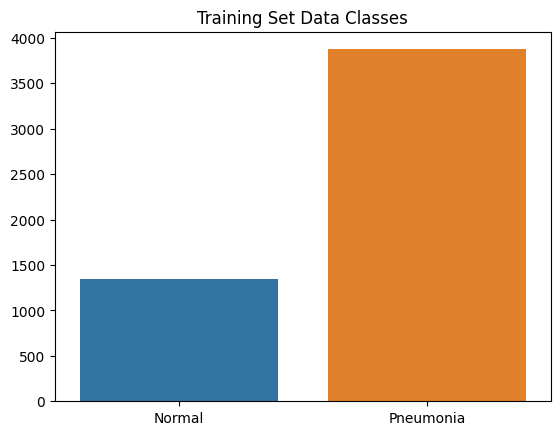

In [7]:
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len( [os.path.join(data_dir+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/train/NORMAL')] )], 
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])] }
)
sns.barplot(data=train_samplesize).set_title('Training Set Data Classes')
plt.show()

#### 3.2.2 Input Tensor Information

**A sample of trainset is a tuple consists of image and class**

In [8]:
Train_set[0]

(tensor([[[0.0863, 0.0941, 0.0941,  ..., 0.3765, 0.3686, 0.3647],
          [0.0902, 0.0941, 0.0941,  ..., 0.3804, 0.3686, 0.3608],
          [0.0941, 0.0941, 0.0902,  ..., 0.3882, 0.3765, 0.3686],
          ...,
          [0.1922, 0.1961, 0.1882,  ..., 0.4667, 0.4667, 0.4667],
          [0.1961, 0.2039, 0.2078,  ..., 0.4824, 0.4863, 0.4824],
          [0.2039, 0.2078, 0.2118,  ..., 0.5059, 0.5020, 0.4980]],
 
         [[0.0863, 0.0941, 0.0941,  ..., 0.3765, 0.3686, 0.3647],
          [0.0902, 0.0941, 0.0941,  ..., 0.3804, 0.3686, 0.3608],
          [0.0941, 0.0941, 0.0902,  ..., 0.3882, 0.3765, 0.3686],
          ...,
          [0.1922, 0.1961, 0.1882,  ..., 0.4667, 0.4667, 0.4667],
          [0.1961, 0.2039, 0.2078,  ..., 0.4824, 0.4863, 0.4824],
          [0.2039, 0.2078, 0.2118,  ..., 0.5059, 0.5020, 0.4980]],
 
         [[0.0863, 0.0941, 0.0941,  ..., 0.3765, 0.3686, 0.3647],
          [0.0902, 0.0941, 0.0941,  ..., 0.3804, 0.3686, 0.3608],
          [0.0941, 0.0941, 0.0902,  ...,

In [9]:
img,lbl=Train_set[0]

print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype} \n")
print(f"Image label: {lbl} : {lbl}")
print(f"Label datatype: {type(lbl)}")

Image shape: torch.Size([3, 1858, 2090])
Image datatype: torch.float32 

Image label: 0 : 0
Label datatype: <class 'int'>


**Plotting the sample**

<Figure size 1000x600 with 0 Axes>

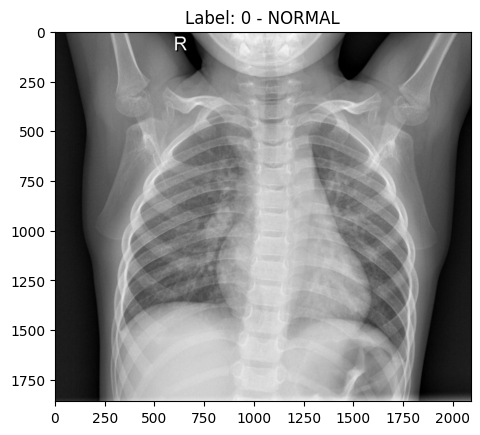

<Figure size 1000x600 with 0 Axes>

In [10]:
plt.imshow(img.permute(1,2,0)) # as image dim[1,28,28] to plot [H,W,C]
plt.title(f"Label: {lbl} - {idx_to_class[lbl]}")
plt.figure(figsize= (10,6))

#### **3.2.3 Plotting random Samples with their equivalent labels**

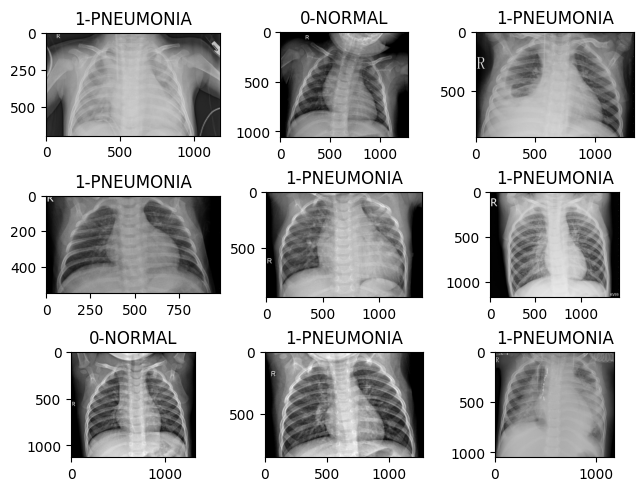

In [11]:
def plot_samples(split_set,preds=None):

    idx_to_class = {split_set.class_to_idx[k]: k for k in split_set.class_to_idx}
    randomlist = random.sample(range(0, len(split_set)), 9)
    #print(randomlist)
    k=0
    figure, ax = plt.subplots(3, 3,constrained_layout = True)

    for i in range(3):
      for j in range(3):
        idx=randomlist[k]
        k+=1
        ax[i, j].imshow(split_set[idx][0].permute(1,2,0))
        
        if  (  (preds is None) ):
            ax[i, j].set_title(f"{split_set[idx][1]}-{idx_to_class[split_set[idx][1]]}", fontsize=12)
        
        else:
            if split_set[idx][1]==preds[idx]:
                check="Correctly_Classified"
            else:
                check="Wrongly_Classified"
 
            ax[i, j].set_title(f"{check} \n Actual:{idx_to_class[split_set[idx][1]]} \n predicted:{idx_to_class[preds[idx]]}"
                               , fontsize=10)
        
plot_samples(Train_set)

### 3.3 **Data Transformation**

In [12]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [13]:
Train_set_Aug = datasets.ImageFolder(os.path.join(data_dir, "train"),transform = train_transforms)
Test_set_Aug = datasets.ImageFolder(os.path.join(data_dir, "test"),transform = test_transforms)
Dev_set_Aug = datasets.ImageFolder(os.path.join(data_dir, 'val'),transform = test_transforms)

In [14]:
img,lbl=Train_set_Aug[0]

print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype} \n")
print(f"Image label: {lbl} : {lbl}")
print(f"Label datatype: {type(lbl)}")

Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32 

Image label: 0 : 0
Label datatype: <class 'int'>


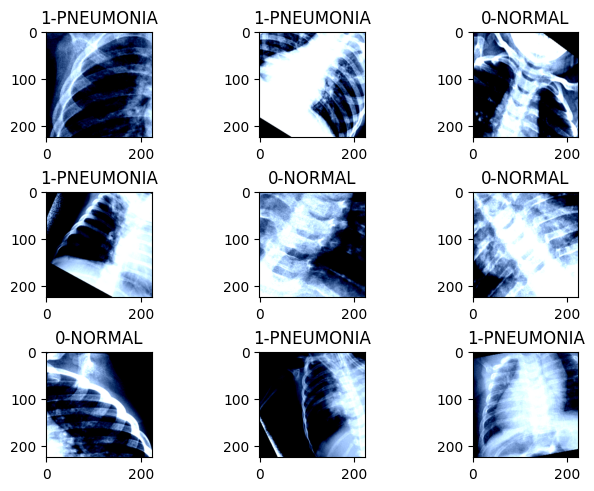

In [15]:
plot_samples(Train_set_Aug)

## 4. DataLoaders

In [16]:
Trainloader = torch.utils.data.DataLoader(Train_set_Aug, batch_size=128, shuffle=True)
Devloader = torch.utils.data.DataLoader(Dev_set_Aug, batch_size=16,shuffle=False)
Testloader=torch.utils.data.DataLoader(Test_set_Aug, batch_size=128,shuffle=False)

print(f"Total no. of batches in trainloader : {len(Trainloader)}")
print(f"Total no. of batches in validloader : {len(Devloader)}")
print(f"Total no. of batches in testloader : {len(Testloader)}")

Total no. of batches in trainloader : 41
Total no. of batches in validloader : 1
Total no. of batches in testloader : 5


## 5. Model

### 5.1 Transfer Learning Class

In [17]:
class Model(nn.Module):
    def __init__(self,model_arch,num_classes=10,device="cuda"):
        super().__init__()
        self.model_arch=model_arch
        self.device=device
        self.num_classes=num_classes
        self.model=torch.hub.load("pytorch/vision", self.model_arch, weights="IMAGENET1K_V1").to(self.device)
        
        # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
        for param in self.model.parameters():
            param.requires_grad = False
            
        layers=[n for n, _ in self.model.named_children()]
        last_layer= layers[-1]
        #print (last_layer)
        
        if last_layer=="fc": #Resnet and shufflenet
            self.in_features=(self.model).fc.in_features
            self.model.fc= torch.nn.Sequential( 
                torch.nn.Linear(in_features=self.in_features,out_features=128),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(in_features=128,
                                out_features=self.num_classes, # same number of output units as our number of classes
                                bias=True)).to(self.device)
            
        elif last_layer=="classifier": #mobileNet and efficientnet and convnext
            self.in_features=(self.model).classifier[-1].in_features
            self.model.classifier[-1]= torch.nn.Sequential(
                torch.nn.Dropout(p=0.2, inplace=True),
                torch.nn.Linear(in_features=self.in_features,out_features=128),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(in_features=128,
                                out_features=self.num_classes, # same number of output units as our number of classes
                                bias=True)).to(self.device)     
            
        elif last_layer=="heads": #VIT_16
            #self.in_features=(self.model).heads.in_features
            self.model.heads= torch.nn.Sequential(
                torch.nn.Linear(in_features=768,out_features=128),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(in_features=128,
                                out_features=self.num_classes, # same number of output units as our number of classes
                                bias=True)).to(self.device)        
        
    def forward(self,x):
        y=self.model(x)
        return (y)

### 5.2 Transfering Learning to Some Model Architectures

#### **Some Model Architectures:**
`Resnet50`
`Mobilenet_version2`
`Convnext_tiny`
`Vision Transformer b16`


In [18]:
models_arch=["vit_b_16","convnext_tiny",'mobilenet_v2','resnet50']
#Some architectures to also considered (efficientnet_v2_m","swin_b","shufflenet_v2_x2_0")

models={}
for model in models_arch:
    # Create Instances of Our Models
    models[model]=Model(model,num_classes=num_classes,device=device)
    
keys=list(models.keys())
keys

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 253MB/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 212MB/s] 
Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 164MB/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|███

['vit_b_16', 'convnext_tiny', 'mobilenet_v2', 'resnet50']

#### Visualizing Vision Transformer Model

In [19]:
summary(models["vit_b_16"], 
        (128,3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

/opt/conda/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/opt/conda/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
Model (Model)                                                     [128, 3, 224, 224]   [128, 2]             --                   Partial
├─VisionTransformer (model)                                       [128, 3, 224, 224]   [128, 2]             768                  Partial
│    └─Conv2d (conv_proj)                                         [128, 3, 224, 224]   [128, 768, 14, 14]   (590,592)            False
│    └─Encoder (encoder)                                          [128, 197, 768]      [128, 197, 768]      151,296              False
│    │    └─Dropout (dropout)                                     [128, 197, 768]      [128, 197, 768]      --                   --
│    │    └─Sequential (layers)                                   [128, 197, 768]      [128, 197, 768]      (85,054,464)         False
│    │    └─LayerNorm (ln)                        

## 6. Loss Functions and Optimizers

In [20]:
loss_fn = nn.CrossEntropyLoss()

def Get_optimizer(model,opt="SGD",lr=3e-3):
    if opt=="SGD":
        return  optim.SGD(model.parameters(), lr=lr)
    elif opt=="Adam":
        return optim.Adam(model.parameters(), lr=lr)
    else:
        return optim.RMSprop(model.parameters(), lr=lr)

## 7. Learning Rate Finder

In [21]:
def Get_LR(Trainloader,model,optimizer,loss_fn,device="cuda"):
    lr_finder = LRFinder(model, optimizer, loss_fn, device=device)
    lr_finder.range_test(Trainloader, end_lr=100, num_iter=100)
    lr_finder.plot() 
    lr_finder.reset()

## 8. Train and Test functions

In [22]:
def train_fn(model,dataloader,loss_fn,optimizer,current_epo,epochs):
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    total_loss, total_acc = 0, 0
    tk=tqdm( dataloader,desc=("Ep"+"[Train]"+str(current_epo+1)+"/"+str(epochs)) )

    #iterations in 1 epoch # iterations=len(trainloader)=901 batches each batch consist of32 images
    for t,data in enumerate(tk):
        images,labels=data
        images,labels=images.to(device) ,labels.to(device)


        # 1. Forward pass
        y_pred=model(images)


        # 2. Calculate  and accumulate loss
        loss=loss_fn(y_pred,labels)
        total_loss+=loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        total_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        tk.set_postfix({"loss":"%3f" %float(total_loss/(t+1)),"acc":"%3f" %float(total_acc/(t+1))})

    return total_loss/len(dataloader), total_acc/len(dataloader)


def train_fn_without_displaying_epochs(model,dataloader,loss_fn,optimizer,current_epo,epochs):
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    total_loss, total_acc = 0, 0
   
    for t,data in enumerate(dataloader):
        images,labels=data
        images,labels=images.to(device) ,labels.to(device)
        y_pred=model(images)
        loss=loss_fn(y_pred,labels)
        total_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        total_acc += (y_pred_class == labels).sum().item()/len(y_pred)

    return total_loss/len(dataloader), total_acc/len(dataloader)

In [23]:
def eval_fn(model,dataloader,loss_fn,current_epo,epochs,phase="test"):

    model.eval()
    total_loss=0.0
    total_acc=0.0
    
    tk=tqdm(dataloader, desc=("Epoch"+"[Test]"+str(current_epo+1)+"/"+str(epochs)) )

    for t,data in enumerate(tk):
        images,labels=data
        images,labels=images.to(device) ,labels.to(device)

        y_pred=model(images)

        loss=loss_fn(y_pred,labels)
        total_loss+=loss.item()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        total_acc += (y_pred_class == labels).sum().item()/len(y_pred)
        tk.set_postfix({"loss":"%3f" %float(total_loss/(t+1)),"acc":"%3f" %float(total_acc/(t+1))})

    return (total_loss/len(dataloader)),(total_acc/len(dataloader))

## 9. main 

In [24]:
def main(model,Trainloader,Devloader,Testloader,loss_fn,optimizer,lr,name,epochs=10,
         Test=False,scheduler_bol=False,nodisplay=False,sch_gamma=0.1,sch_step=5,save_weights=False):
    
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=sch_step,gamma=sch_gamma)
    if not Test:
        best_train_loss=np.Inf
        best_train_acc=0
        valid_losses=[]
        for i in range(epochs):
            if not nodisplay:
                train_loss , train_acc=train_fn(model, Trainloader, loss_fn, optimizer , i,epochs)
                #valid_loss , valid_acc=eval_fn (model, Devloader,   loss_fn,  i, epochs)
            else:
                train_loss , train_acc=train_fn_without_displaying_epochs(model, 
                                                                         Trainloader, loss_fn, optimizer , i,epochs)
            if scheduler_bol:
                scheduler.step()

            if train_loss <best_train_loss:
                if save_weights:
                    torch.save(model.state_dict(),f"final_best_weights_{name}.pt")
                #print('best weights saved')
                best_train_loss=train_loss
                best_train_acc=train_acc
                

        #valid_losses.append(valid_loss)
        #print (f"best_valid_acc== {best_valid_acc}")
        if  nodisplay:
                print (f"Ep [Train] {str(epochs)}/{str(epochs)} :loss={best_train_loss}, acc={best_train_acc}")
            
        Test_loss , Test_acc=eval_fn (model, Testloader,   loss_fn, 0,1,phase="test")
    
    else:
        Test_loss , Test_acc=eval_fn (model, Testloader,   loss_fn, 0,1,phase="test")

## 10. Taining and Testing
### 10.1 Trying Different model Architectures for 5 epochs per each

In [25]:
for k in models:
    lr=3e-3
    print (f"Training {k} Model with intial LR {lr}")
    main(models[k],Trainloader,Devloader,Testloader,loss_fn,
         optimizer=Get_optimizer(models[k],opt="SGD",lr=lr),
         lr=lr,name=k,epochs=5,save_weights=True,nodisplay=True) #nodisplay=True
    print()

Training vit_b_16 Model with intial LR 0.003
Ep [Train] 5/5 :loss=0.3990635791929757, acc=0.8260924796747967


Epoch[Test]1/1: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it, loss=0.476469, acc=0.799107]



Training convnext_tiny Model with intial LR 0.003
Ep [Train] 5/5 :loss=0.4918837838056611, acc=0.7433943089430894


Epoch[Test]1/1: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it, loss=0.553120, acc=0.668750]



Training mobilenet_v2 Model with intial LR 0.003
Ep [Train] 5/5 :loss=0.4681430277301044, acc=0.7550813008130081


Epoch[Test]1/1: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it, loss=0.552562, acc=0.676116]



Training resnet50 Model with intial LR 0.003
Ep [Train] 5/5 :loss=0.4268487284823162, acc=0.7884908536585366


Epoch[Test]1/1: 100%|██████████| 5/5 [00:11<00:00,  2.35s/it, loss=0.508819, acc=0.757589]

### 10.2 Choose a model architecture for training 
let's select Vision Transformer (VIT_b16), as it has the least error 

In [26]:
model=Model("vit_b_16",num_classes=num_classes,device=device)
optimizer=Get_optimizer(model,opt="SGD")
lr=3e-3
main(model,Trainloader,Devloader,Testloader,loss_fn,optimizer=optimizer,lr=lr,name=keys[0],epochs=40,save_weights=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Epoch[Test]1/1: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it, loss=0.323592, acc=0.846205]


let's find Lr after 40 epochs of training

Train for another 20 epochs with ADAM Optimizer

In [28]:
main(model,Trainloader,Devloader,Testloader,loss_fn,optimizer2,lr=1e-2,name=(keys[0]+"2"),scheduler_bol=True,epochs=20,save_weights=True)

Epoch[Test]1/1: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it, loss=0.253292, acc=0.899554]


## 11. Result Analysis 

In [29]:
def predictions(model,dataloader,device="cuda"):

    model.eval()
    labels=[]
    preds=[]
    
    for data in (dataloader):
        image,label=data
        image,label=image.to(device) ,label.to(device)
        labels.append(label.detach().cpu().numpy())

        y_pred=model(image)
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        preds.append(y_pred_class.detach().cpu().numpy())

    labels = [item for sublist in labels for item in sublist]
    preds = [item for sublist in preds for item in sublist]
    return labels,preds

In [30]:
labels,preds=predictions(model,Testloader,device="cuda")

### 11.1 Confusion Matrix

Unnormazlized Confusion Matrix

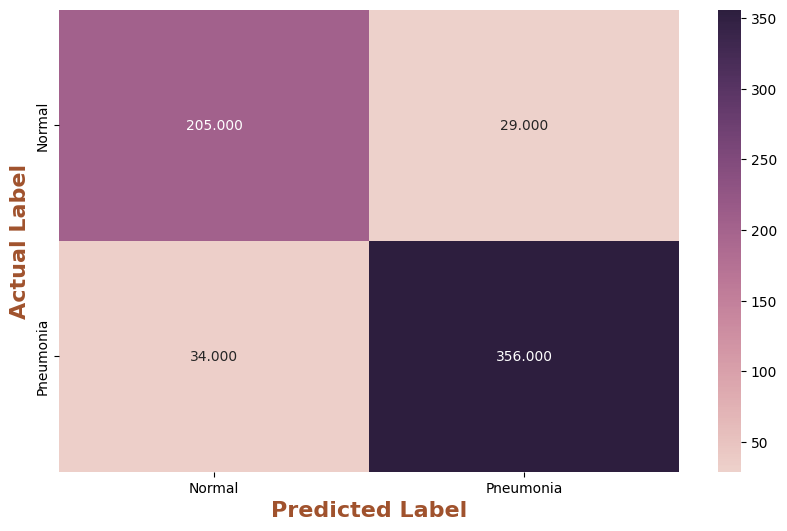

In [31]:
conf=confusion_matrix(labels, preds)
labels_name=['Normal', 'Pneumonia']

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(conf, annot=True,xticklabels=labels_name,yticklabels=labels_name,fmt='.3f', 
                 cmap=sns.cubehelix_palette(as_cmap=True))

font1 = {'family': 'sans-serif','weight': 'bold','color':"sienna",'size': 16}
ax.set_xlabel('Predicted Label',fontdict=font1)
ax.set_ylabel('Actual Label',fontdict=font1)
plt.show()

Normazlized Confusion Matrix

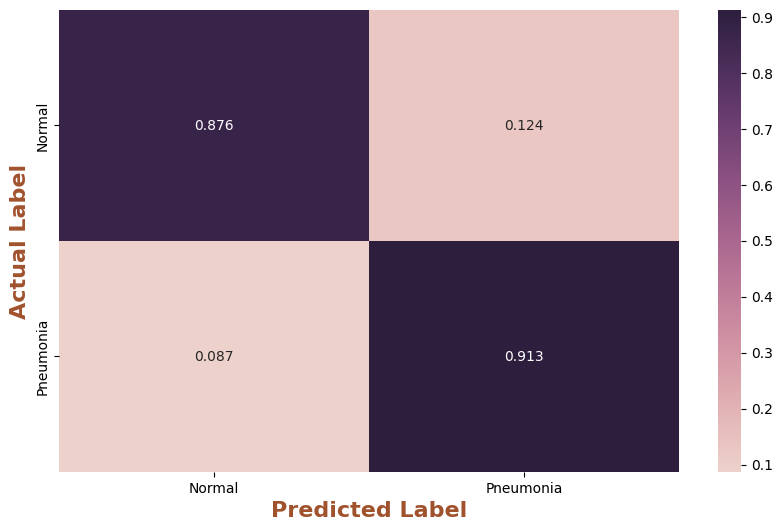

In [32]:
conf=confusion_matrix(labels, preds,normalize='true')
labels_name=['Normal', 'Pneumonia']


fig, ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(conf, annot=True,xticklabels=labels_name,yticklabels=labels_name,fmt='.3f', 
                 cmap=sns.cubehelix_palette(as_cmap=True))

font1 = {'family': 'sans-serif','weight': 'bold','color':"sienna",'size': 16}
ax.set_xlabel('Predicted Label',fontdict=font1)
ax.set_ylabel('Actual Label',fontdict=font1)
plt.show()

### 11.2 Classification Metrics

In [33]:
Report=classification_report(labels, preds,digits=4)
print(Report)

              precision    recall  f1-score   support

           0     0.8577    0.8761    0.8668       234
           1     0.9247    0.9128    0.9187       390

    accuracy                         0.8990       624
   macro avg     0.8912    0.8944    0.8928       624
weighted avg     0.8996    0.8990    0.8992       624



### 11.3 Plot Prediction VS Actual Labels

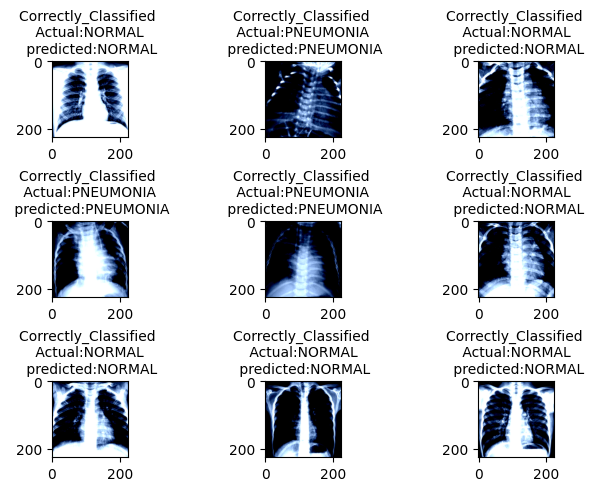

In [34]:
plot_samples(Test_set_Aug,preds=preds)